In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import HGate, RYGate, RXGate, XGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# General n-level Quantum Galton Board algorithm

In [18]:
def _pair_sequence_shift_third(r: int, centre: int, right_edge: int) -> list[tuple[int, int]]:
    pairs = []
    first, second = (centre - r, centre - r + 1), (centre - r + 1, centre - r + 2)
    pairs.extend([first, second])

    if r == 1:  
        return pairs

    gap = 2 * r - 3
    third = (second[1] + gap, second[1] + gap + 1)
    if third[1] <= right_edge:
        pairs.append(third)

    cur = third[0] - 1
    while len(pairs) < 2 * r and cur >= first[0]:
        pair = (cur, cur + 1)
        if pair not in pairs:
            pairs.append(pair)
        cur -= 1
    return pairs

def galton_box_shifted(n: int, coin_gate, *, draw=False) -> QuantumCircuit:
    """
    Quantum Galton Box with customizable coin operations
    
    Args:
        n (int): Number of rows/levels in the Galton box
        coin_gate: Quantum gate or function that returns a gate.
                   If function, should take row index (r) as input.
        draw (bool): Whether to draw the circuit
    
    Returns:
        QuantumCircuit: Configured Galton box circuit
    """
    total_q = 2 * n + 2
    data_q = n + 1
    centre = n + 1
    right = 2*n + 1
    anc = 0

    #Create quantum registers
    q = QuantumRegister(total_q, 'q')
    c = ClassicalRegister(data_q, 'c')
    qc = QuantumCircuit(q, c)
    
    # Initialize ball at center
    qc.x(centre)

    # Process rows 1 to n-1 with custom coin gate
    for r in range(1, n):
        qc.reset(anc)
        
        # Apply custom coin operation
        if callable(coin_gate):
            # If coin_gate is a function, call it with current row index
            gate = coin_gate(r)
        else:
            # Use the gate directly
            gate = coin_gate
            
        qc.append(gate, [anc])

        # Get swap pairs for current row
        pairs = _pair_sequence_shift_third(r, centre, right)

        # Apply controlled-swap operations
        for i, (a, b) in enumerate(pairs):
            qc.cswap(anc, a, b)
            
            # Apply CX to next control
            if i < len(pairs) - 1:
                next_a, _ = pairs[i + 1]
                cx_control = b if next_a > a else a
                qc.cx(cx_control, anc)

    # Process final row (n) with custom coin gate
    qc.reset(anc)
    
    # Apply same coin selection logic for final row
    if callable(coin_gate):
        gate = coin_gate(n)  # Use row index n for final row
    else:
        gate = coin_gate
    qc.append(gate, [anc])

    # Final swap sequence
    i = 0
    while i <= 2*n -2:
        qc.cswap(anc, i + 1, i + 2)
        qc.cx(i + 2, anc)
        qc.cswap(anc, i + 2, i + 3)
        if i + 4 < 2*n +1:
            qc.cx(i + 3, anc)
        i += 2
        
    if draw:
        qc.draw('mpl', style='clifford', fold=True)
        plt.show()

    # Measure all data qubits
    for i in range(0, data_q):
        qc.measure(q[2*i+1], c[i])

    return qc


# Generalizing post processing to obtain the normal distribution
def post_process_histogram(memory_bitstrings, block_size):
    
    # one hot encoding of the even bitstrings
    unique_even = sorted(set(memory_bitstrings))
    bitstring_to_int = {b: i for i, b in enumerate(unique_even)}

    # one hot encoding to integer labels
    one_hot_values = [bitstring_to_int[b] for b in memory_bitstrings]

    max_value = max(one_hot_values)
    bin_size= (block_size * max_value) + 1  # Adjust bin size based on block size and max value

    # split into blocks of 8, compute sum per block (8 is the paper's choice) and note the frequency of each sum
    num_blocks = len(one_hot_values) // block_size
    trimmed_values = one_hot_values[:num_blocks * block_size]
    reshaped = np.array(trimmed_values).reshape((num_blocks, block_size))
    block_sums = reshaped.sum(axis=1)

    return memory_bitstrings, block_sums, bin_size

### Testing for a $5-$ level Quantum Galton Board

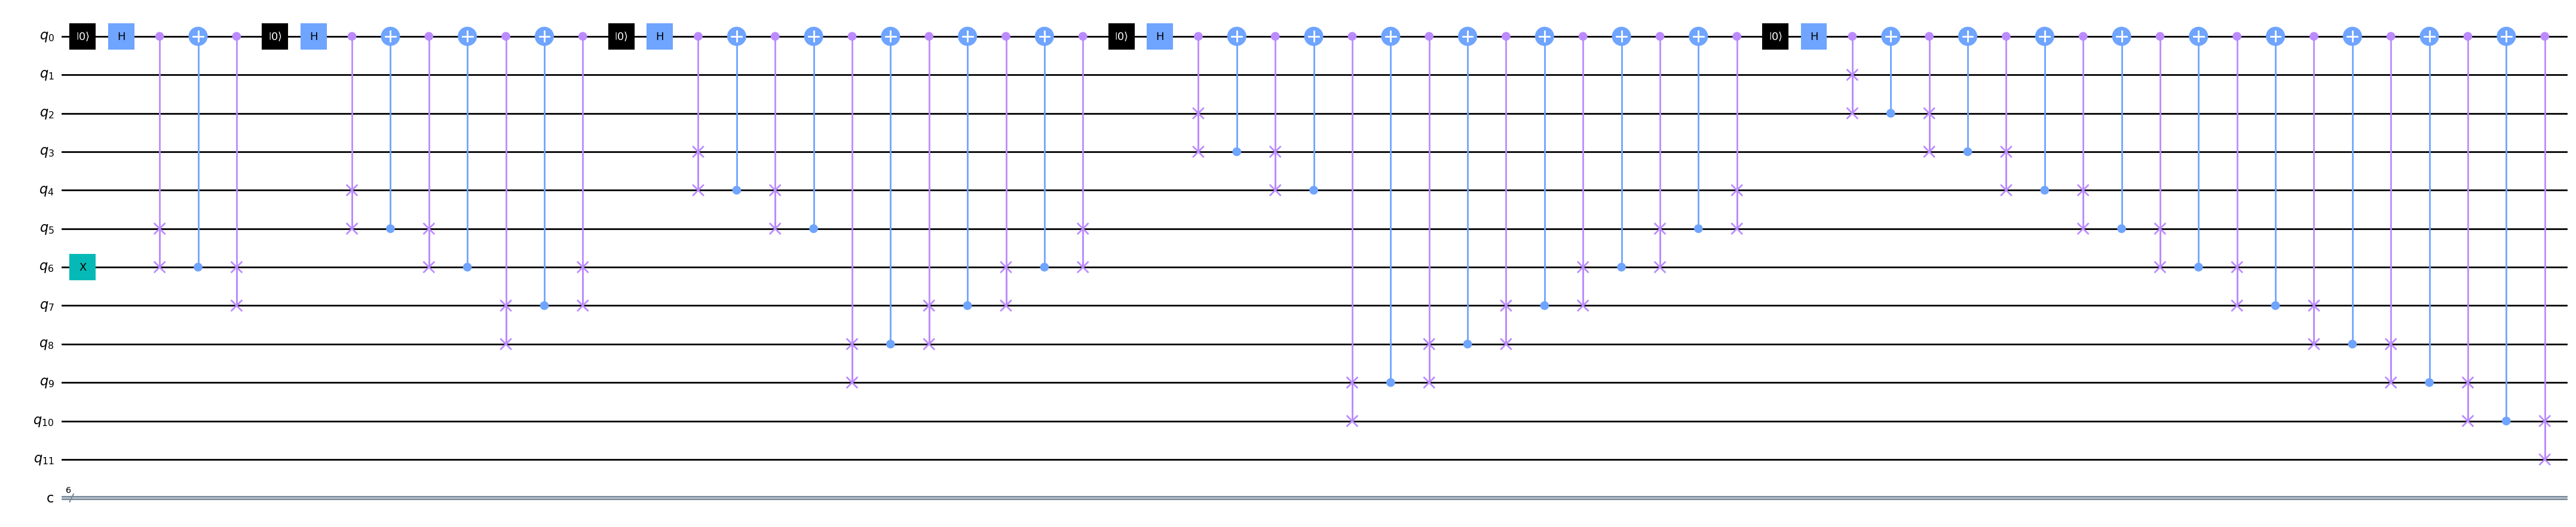

In [7]:
qc = galton_box_shifted(5, HGate(), draw=True)
backend = Aer.get_backend('qasm_simulator')

compiled = transpile(qc, backend)
job = backend.run(compiled, shots=100000, memory=True)
memory_counts = job.result().get_memory()  # to get the list of 20000 bitstrings in order of experiments/shots

### Post processing and fitting to a normal distribution

Block Size 5: Best-fit Normal Distribution: mean = 12.52, std = 2.49
Block Size 10: Best-fit Normal Distribution: mean = 25.04, std = 3.51
Block Size 15: Best-fit Normal Distribution: mean = 37.56, std = 4.32
Block Size 20: Best-fit Normal Distribution: mean = 50.08, std = 4.99


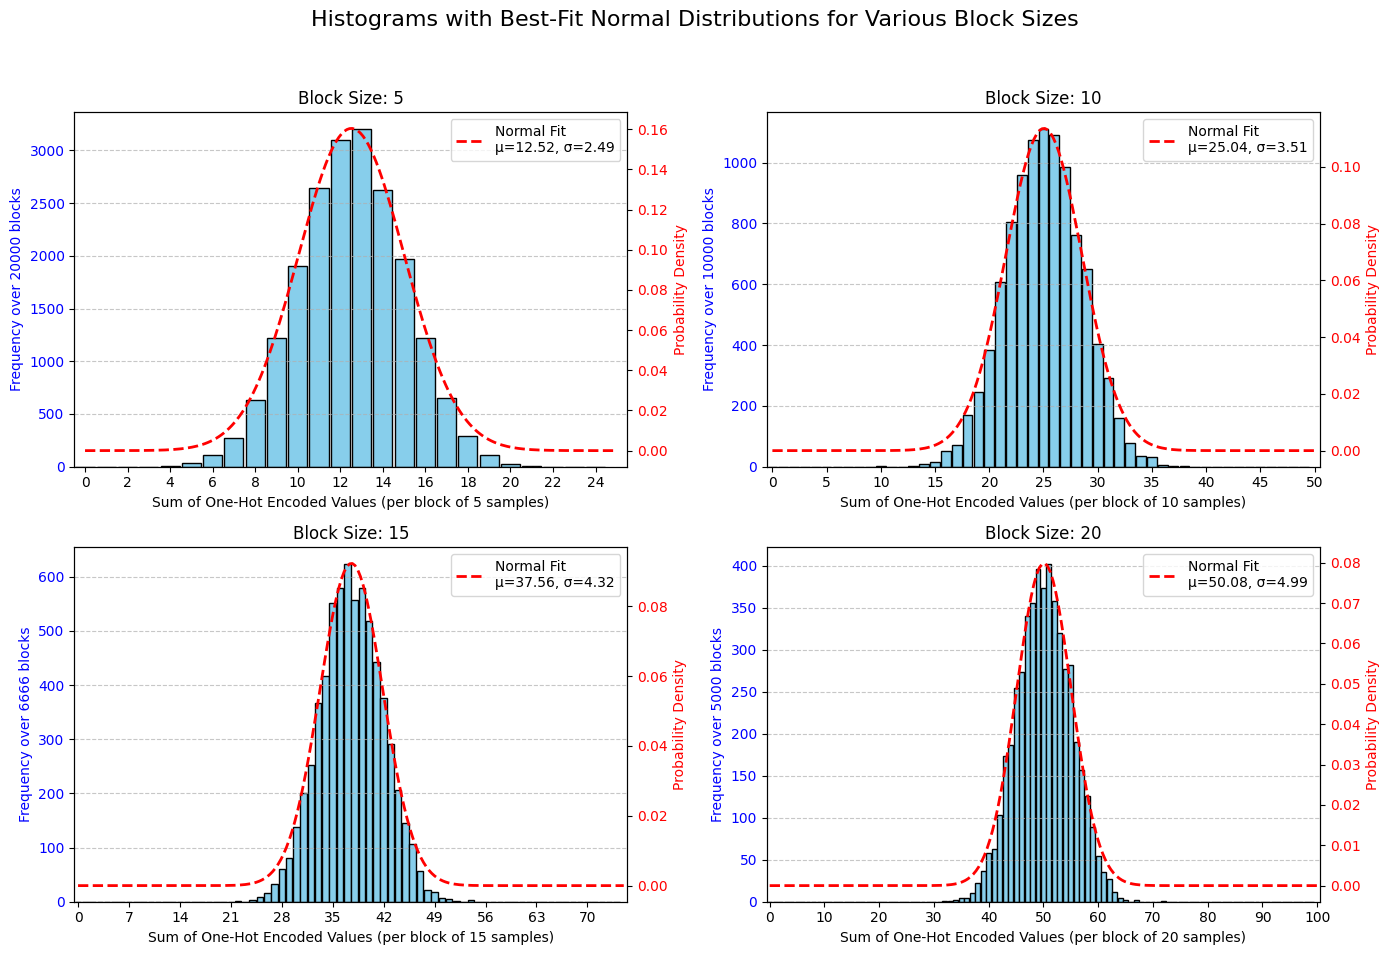

In [ ]:
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import kstest, norm

block_size_list = [5,10,15,20]  # Block size for summation

fig_outer, axs_outer = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Flatten the axes array for easier iteration if you prefer, or use 2D indexing
axs_outer_flat = axs_outer.flatten()

for i in range(len(block_size_list)):
    even_bitstrings, block_sums, bin_size = post_process_histogram(memory_counts, block_size_list[i])
    
    # Fit normal distribution
    mu, std = norm.fit(block_sums)   
    print(f"Block Size {block_size_list[i]}: Best-fit Normal Distribution: mean = {mu:.2f}, std = {std:.2f}")
    
    # Select the current subplot axes
    ax1 = axs_outer_flat[i]
    ax2 = ax1.twinx() # Create a twin axis for the PDF on the current subplot

    # Histogram (left axis)
    count, bins, _ = ax1.hist(block_sums, bins=range(0, bin_size), align='left', 
                              rwidth=0.9, color='skyblue', edgecolor='black')
    
    xmin_pdf, xmax_pdf = 0, bin_size - 1 # Adjusted to cover full possible range of sums
    x_pdf = np.linspace(xmin_pdf, xmax_pdf, 200) # More points for smoother curve
    p = norm.pdf(x_pdf, mu, std)
    ax2.plot(x_pdf, p, 'r--', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
    
    # Add legend to the twin axis for the PDF curve
    ax2.legend(loc='upper right')

    # Labels and formatting for the current subplot
    ax1.set_xlabel(f"Sum of One-Hot Encoded Values (per block of {block_size_list[i]} samples)")
    # Assuming 100000 total samples, number of blocks is total_samples // block_size
    num_blocks_for_label = 100000 // block_size_list[i]
    ax1.set_ylabel(f"Frequency over {num_blocks_for_label} blocks", color='blue')
    ax2.set_ylabel("Probability Density", color='red')
    
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')

    # Adjust x-ticks based on the block size for better readability
    # A more robust way to set xticks is to ensure they are within the data range
    tick_interval = max(1, bin_size // 10) # Roughly 10 ticks, at least 1
    ax1.set_xticks(np.arange(0, bin_size, tick_interval))
    ax1.set_xlim(-0.5, bin_size - 0.5) # Set x-limits to prevent bins from being cut off

    ax1.set_title(f"Block Size: {block_size_list[i]}") # Title for each subplot
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust overall title and layout
fig_outer.suptitle("Histograms with Best-Fit Normal Distributions for Various Block Sizes", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()


___
___

## Biased Quantum Pegs

By replacing the Hadamard gate with an $R_x$ rotation gate, we introduce **bias** into the quantum peg behavior, creating asymmetric probability distributions with distinct characteristics.

- **Hadamard Gate**: Creates equal superposition (50/50 probability split)
- **$R_x(\theta)$ Gate**: Introduces bias toward one direction, creating unequal branching probabilities

#### Resulting Distribution Properties

When using biased $R_x$ gates instead of symmetric Hadamard gates, the post-processed normal distributions exhibit:

1. **Increased/Decreased Standard Deviation**: Broader, more or spread-out distributions (if angle greater than $\pi/2$ ). Narrow distribution otherwise.
2. **Shifted Mean Values**: Distribution centers move toward lower values (left-shifted) depending on the rotation angle
3. **Shifted Peak Heights**


This demonstrates how quantum gate selection directly controls the statistical properties of the emergent probability distributions in quantum Galton boards. 

Processing Gate: HGate
  Gate HGate: mean = 24.98, std = 3.56
Processing Gate: RX($\pi/6$)
  Gate RX($\pi/6$): mean = 11.28, std = 1.58
Processing Gate: RX($\pi/3$)
  Gate RX($\pi/3$): mean = 24.15, std = 2.71
Processing Gate: RX($2\pi/3$)
  Gate RX($2\pi/3$): mean = 18.87, std = 4.60


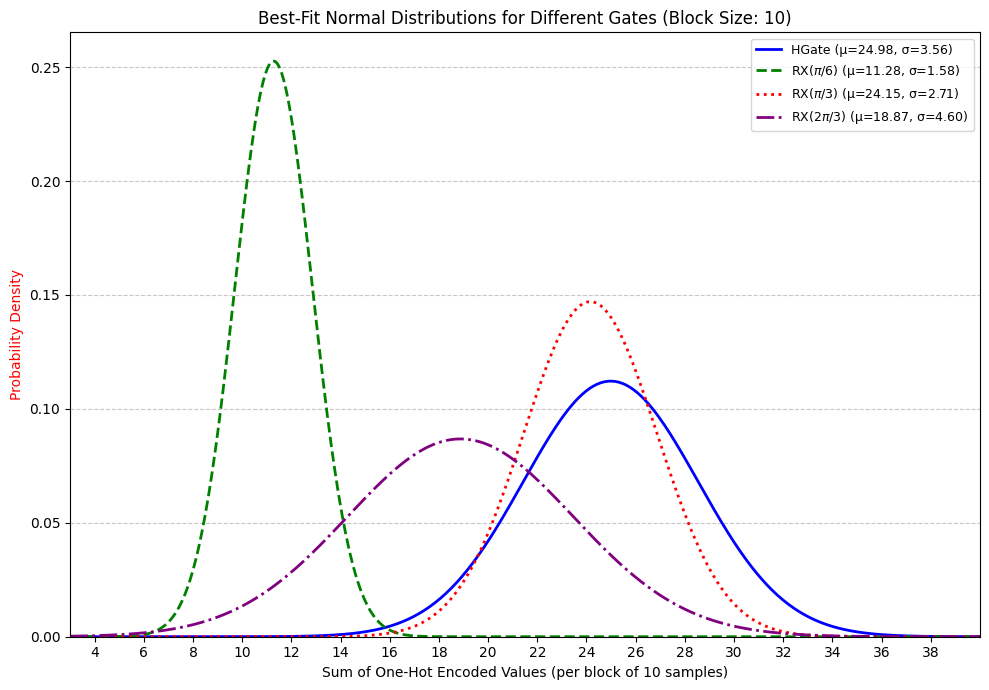

In [ ]:
from scipy.stats import norm
gate_biased = [HGate(), RXGate(np.pi/6), RXGate(np.pi/3), RXGate(2*np.pi/3)]
fixed_block_size = 10 # Fixed block size

# Store data directly for each gate
data_to_plot_by_gate = {}

for gate in gate_biased:
    qc = galton_box_shifted(5, gate, draw=False) # Assuming 5 qubits
    backend = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, backend)
    job = backend.run(compiled, shots=100000, memory=True)
    memory_counts = job.result().get_memory()

    # Get a descriptive name for the gate for plotting
    if isinstance(gate, HGate):
        gate_name_str = "HGate"
    elif isinstance(gate, RXGate):
        # Format RXGate's angle nicely for the label
        angle_val = gate.params[0]
        if angle_val == np.pi/6:
            gate_name_str = r"RX($\pi/6$)"
        elif angle_val == np.pi/3:
            gate_name_str = r"RX($\pi/3$)"
        elif angle_val == 2*np.pi/3:
            gate_name_str = r"RX($2\pi/3$)"
        else:
            gate_name_str = f"RX({angle_val:.2f})"
    else:
        gate_name_str = str(gate) # Fallback for other gate types

    print(f"Processing Gate: {gate_name_str}")

    _, block_sums, bin_size = post_process_histogram(memory_counts, fixed_block_size)
    mu, std = norm.fit(block_sums)
    data_to_plot_by_gate[gate_name_str] = {'mu': mu, 'std': std, 'block_sums': block_sums, 'bin_size': bin_size}
    print(f"  Gate {gate_name_str}: mean = {mu:.2f}, std = {std:.2f}")



fig, ax = plt.subplots(figsize=(10, 7))
ax2 = ax

all_block_sums = []
for gate_name_str in data_to_plot_by_gate:
    all_block_sums.extend(data_to_plot_by_gate[gate_name_str]['block_sums'])

# Determine overall x-axis range
if all_block_sums:
    min_overall_x = min(all_block_sums)
    max_overall_x = max(all_block_sums)
else:
    min_overall_x = 0
    max_overall_x = 10 # Default range if no data

x_plot_range = np.linspace(min_overall_x - 1, max_overall_x + 1, 500) # Denser points for smooth curves

# Define a color and linestyle cycle for better visual distinction
colors = ['blue', 'green', 'red', 'purple']
linestyles = ['-', '--', ':', '-.']

for i, gate_name_str in enumerate(data_to_plot_by_gate):
    data = data_to_plot_by_gate[gate_name_str]
    mu, std = data['mu'], data['std']
    
    # Calculate PDF for the current gate's fit
    p = norm.pdf(x_plot_range, mu, std)
    
    # Plot the normal fit curve
    ax2.plot(x_plot_range, p, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)],
             linewidth=2, label=f'{gate_name_str} (μ={mu:.2f}, σ={std:.2f})')

# Set labels and title
ax.set_xlabel(f"Sum of One-Hot Encoded Values (per block of {fixed_block_size} samples)")
ax2.set_ylabel("Probability Density", color='red')
ax.set_title(f"Best-Fit Normal Distributions for Different Gates (Block Size: {fixed_block_size})")

# Adjust y-axis for ax2 (probability density) to fit all curves
ax2.set_ylim(bottom=0) # Ensure PDF starts from 0

# Adjust x-axis ticks for clarity
ax.set_xlim(min_overall_x - 1, max_overall_x + 1)
ax.set_xticks(range(int(min_overall_x), int(max_overall_x) + 1, max(1, fixed_block_size // 5)))

ax.grid(axis='y', linestyle='--', alpha=0.7) # Grid on primary y-axis
ax2.legend(loc='upper right', fontsize=9) # Legend for the curves

plt.tight_layout()
plt.show()

### Thus a quantum peg with bias can give rise to normal distributions with varied characteristics. 

____
____

## Exponential distribution

To generate an exponential-like distribution from a quantum Galton board, we need to modify the core "coin" operation. In a classical Galton board, the probability of a ball falling left or right is usually fixed at 0.5. To get a normal distribution, the probability remains constant at each level. For an exponential distribution, however, the probability of the particle moving in a certain direction must decay over time.

This can be achieved by constructing a quantum gate whose rotation angle is dependent on the row number, $r$, of the Galton board.

#### The Role of the $R_x$ Gate

The $R_x(\theta)$ rotation gate is used to control this probability. When applied to a qubit initialized to $|0\rangle$, it transforms the state to:

$$R_x(\theta)|0\rangle = \cos(\frac{\theta}{2})|0\rangle - i\sin(\frac{\theta}{2})|1\rangle$$

The probabilities of measuring $|0\rangle$ or $|1\rangle$ on this qubit are:

* $P(|0\rangle) = \cos^2(\frac{\theta}{2})$
* $P(|1\rangle) = \sin^2(\frac{\theta}{2})$

In our setup, an ancilla qubit acts as the "coin." We link the measurement of $|1\rangle$ on this coin qubit to the particle moving one step to the right (e.g., via a controlled-swap gate). Thus, the probability of moving right is $P_{right} = P(|1\rangle) = \sin^2(\frac{\theta}{2})$.


#### Constructing the Exponential Decay

For an exponential distribution, we need the probability of moving right to decrease as the number of steps ($r$) increases. We chose a row dependent probability function, 

$$P_{right}(r) \propto 0.5 + 0.1 r$$

where $r$ is the row number of the Galton board.

To connect this to our $R_x$ gate, we set:

$$\cos^2(\frac{\theta_r}{2}) =  min(1, P_{right}(r))$$


This $\theta_r$ is the angle we pass to the $R_x$ gate at each row $r$. The result is a circuit where the particle has a high probability of moving left at the beginning, but this probability decays with each subsequent step. The final distribution of the particle's position will therefore exhibit an exponential decay pattern.

#### Note that the exponential distribution can be observed only after a specific threshold for the size of the Galton board. This is because for smaller boards the number of possible states in the final superposition is low. 


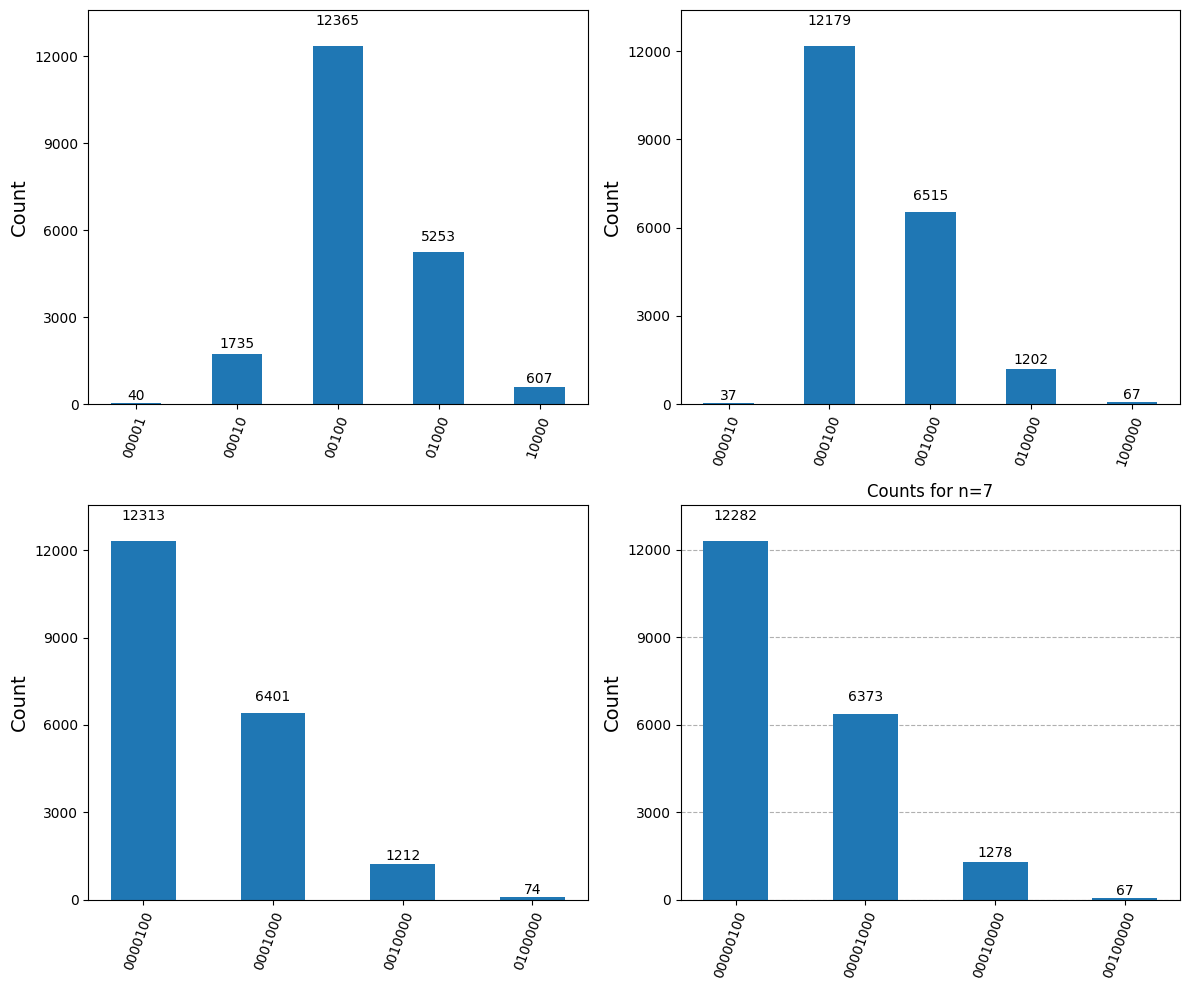

In [22]:
from scipy.optimize import curve_fit

def row_dependent_gate_right(r):
    p = 0.5 + 0.1* r  
    p = min(1.0, p)  # Ensure p is in the range [0, 1]
    theta = 2 * np.arccos(np.sqrt(p))
    return RXGate(theta)

gate_set= [row_dependent_gate_right]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 

n_values = [4, 5, 6, 7]

for i, n in enumerate(n_values):
    for gate in gate_set:
        qc = galton_box_shifted(n, gate)
        backend = Aer.get_backend('qasm_simulator')
        compiled_circuit = transpile(qc, backend)
        job = backend.run(compiled_circuit, shots=20000)
        counts = job.result().get_counts()
        plot_histogram(counts, ax=axes[i], title=f'Counts for n={n}')

plt.tight_layout()
plt.show()



___
___

## 3 level fine grained QGB

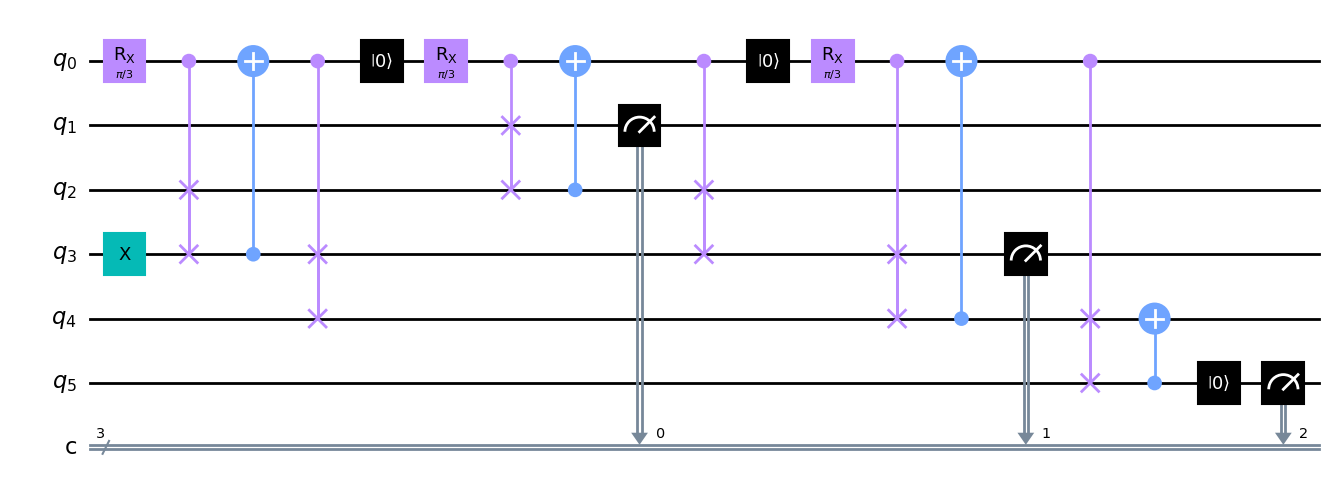

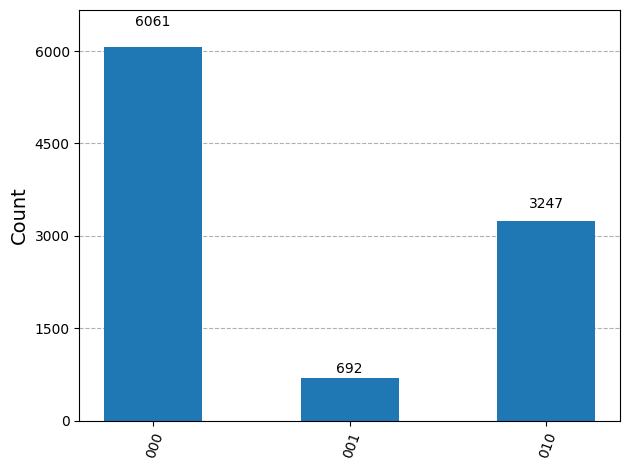

In [ ]:
q = QuantumRegister(6, 'q')
c = ClassicalRegister(3, 'c')
qc = QuantumCircuit(q, c)

theta= np.pi/3 


qc.x(q[3])
# qc.h(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[2], q[3])
qc.cx(q[3], q[0])
qc.cswap(q[0], q[3], q[4])

qc.reset(q[0])
# qc.h(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[1], q[2])
qc.cx(q[2], q[0])
qc.cswap(q[0], q[2], q[3])
# qc.cx(q[3], q[0])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[3], q[4])
qc.cx(q[4], q[0])
qc.cswap(q[0], q[4], q[5])

qc.cx(q[5], q[4])
qc.reset(q[5])

for i in range(0,3):
    qc.measure(q[2*i + 1], c[i])

qc.draw(output='mpl', style='clifford', fold=-1) 
plt.show()

backend = Aer.get_backend('qasm_simulator')
compiled = transpile(qc, backend)
job = backend.run(compiled, shots=1e4)
counts = job.result().get_counts()

plot_histogram(counts)
plt.show()


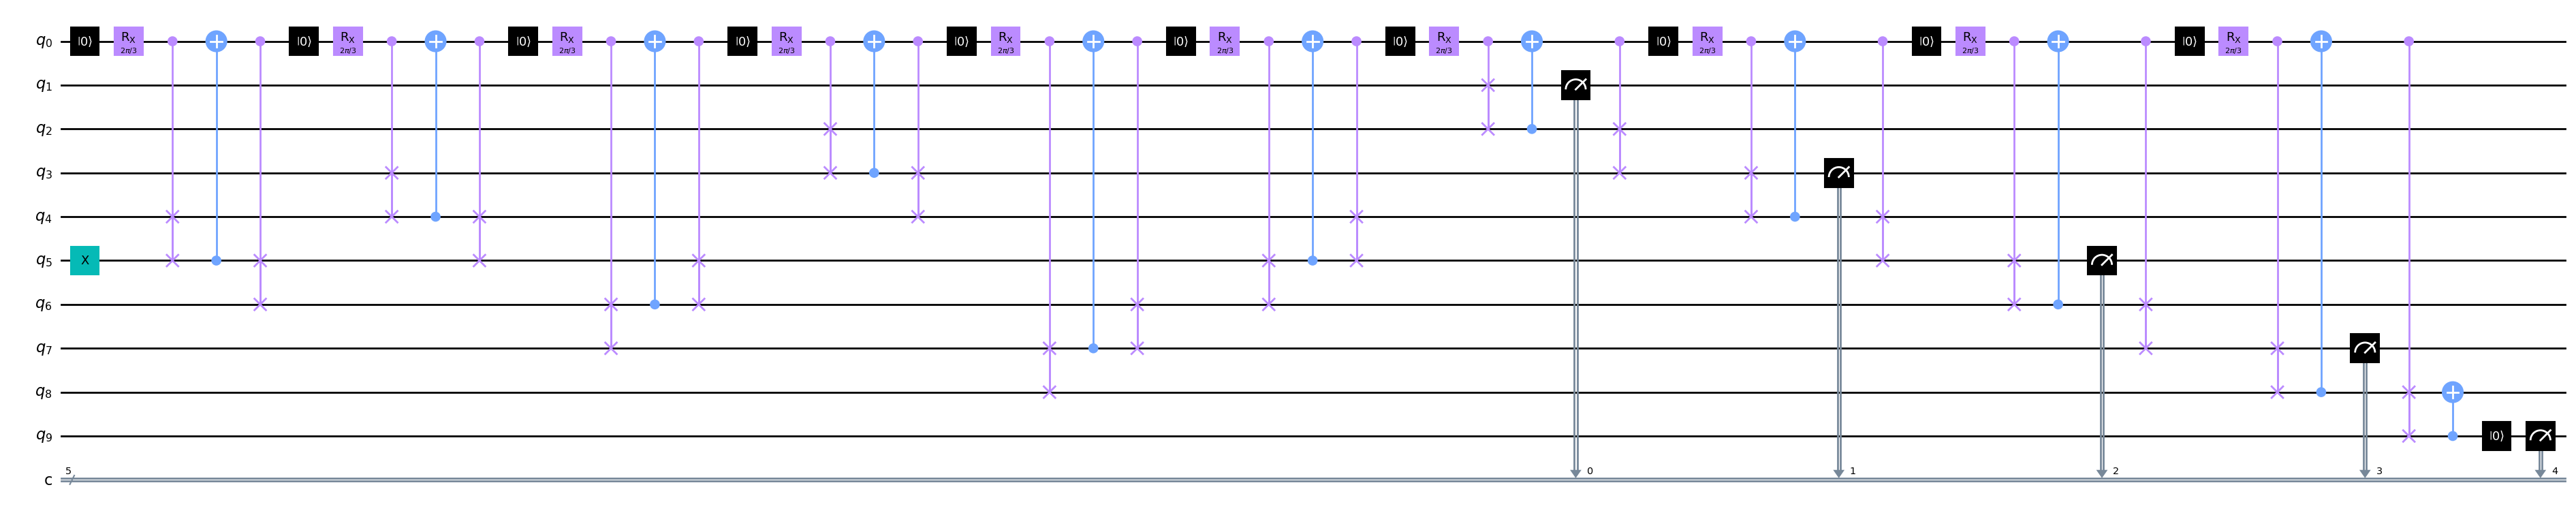

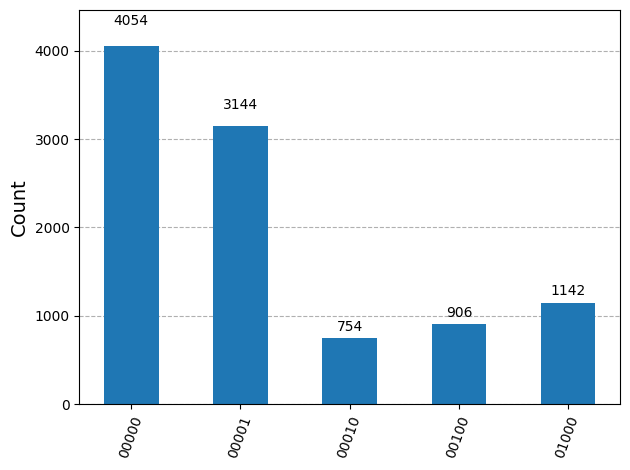

In [ ]:
q = QuantumRegister(10, 'q')
c = ClassicalRegister(5, 'c')
qc = QuantumCircuit(q, c)

theta = 2*np.pi/3

qc.reset(q[0])
qc.x(q[5])
qc.rx(theta, q[0])
qc.cswap(q[0], q[4], q[5])
qc.cx(q[5], q[0])
qc.cswap(q[0], q[5], q[6])

qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[3], q[4])
qc.cx(q[4], q[0])
qc.cswap(q[0], q[4], q[5])
# qc.cx(q[5], q[0])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[6], q[7])
qc.cx(q[6], q[0])
qc.cswap(q[0], q[5], q[6])

qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[2], q[3])
qc.cx(q[3], q[0])
qc.cswap(q[0], q[3], q[4])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[7], q[8])
qc.cx(q[7], q[0])
qc.cswap(q[0], q[6], q[7])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0],q[5],q[6])
qc.cx(q[5],q[0])
qc.cswap(q[0],q[4],q[5])

qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[1], q[2])
qc.cx(q[2], q[0])
qc.cswap(q[0], q[2], q[3])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[3], q[4])
qc.cx(q[4], q[0])
qc.cswap(q[0], q[4], q[5])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[5], q[6])
qc.cx(q[6], q[0])
qc.cswap(q[0], q[6], q[7])
qc.reset(q[0])
qc.rx(theta, q[0])
qc.cswap(q[0], q[7], q[8])
qc.cx(q[8], q[0])
qc.cswap(q[0], q[8], q[9])

qc.cx(q[9], q[8])
qc.reset(q[9])

for i in range(0, 5):
    qc.measure(q[2*i+1], c[i])

qc.draw(output='mpl', style='clifford', fold=-1)
plt.show()

backend = Aer.get_backend('qasm_simulator')
compiled = transpile(qc, backend)
job = backend.run(compiled, shots=1e4)
counts = job.result().get_counts()

plot_histogram(counts)
plt.show()

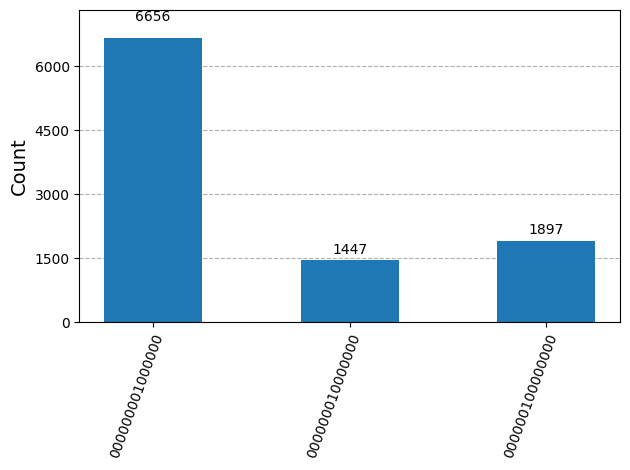

In [4]:

def galton_board_hadamard_walk(n: int, *, draw=False) -> QuantumCircuit:
    """
    Quantum Galton Box configured for a 1D Hadamard walk.
    
    Args:
        n (int): Number of steps in the walk.
        draw (bool): Whether to draw the circuit.
    
    Returns:
        QuantumCircuit: Configured Hadamard walk circuit.
    """
    # The number of data qubits required is 2*n+1 to accommodate
    # the maximum possible spread of the walk.
    # The walk starts at position n, so it can go from 0 to 2n.
    data_q_size = 2 * n + 1
    
    # We need a total of (2n + 1) data qubits + 1 ancilla qubit for the coin
    q = QuantumRegister(data_q_size + 1, 'q')
    c = ClassicalRegister(data_q_size, 'c')
    qc = QuantumCircuit(q, c)

    # The ancilla qubit for the coin operation is the last qubit
    coin_q = q[data_q_size]
    
    # Initialize the particle's position at n
    particle_pos = n
    qc.x(q[particle_pos])

    # Perform the n steps of the Hadamard walk
    for r in range(n):
        qc.h(coin_q)
        qc.cswap(coin_q, q[particle_pos], q[particle_pos + 1])

        qc.x(coin_q)
        qc.cswap(coin_q, q[particle_pos], q[particle_pos - 1])
        qc.x(coin_q) # Reset the coin qubit


    for i in range(data_q_size):
        qc.measure(q[i], c[i])

    if draw:
        qc.draw('mpl', style='clifford', fold=True)
        plt.show()

    return qc

n_steps = 7
hadamard_walk_circuit = galton_board_hadamard_walk(n=n_steps, draw=False)
backend = Aer.get_backend('qasm_simulator')
compiled = transpile(hadamard_walk_circuit, backend)
job = backend.run(compiled, shots=1e4)
counts = job.result().get_counts()

plot_histogram(counts)
plt.show()

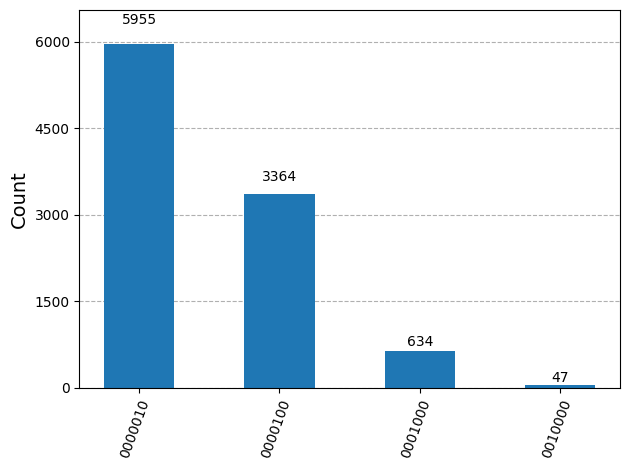

In [2]:
def galton_board_exponential_walk(n: int, lambda_exp: float, *, draw=False) -> QuantumCircuit:
    """
    Quantum Galton board configured for an exponential-like distribution.
    
    This simulation models a particle that has a decreasing probability of moving to the right
    at each step, controlled by a rotation gate.

    Args:
        n (int): Number of steps in the walk.
        lambda_exp (float): The decay parameter for the exponential distribution.
        draw (bool): Whether to draw the circuit.
    
    Returns:
        QuantumCircuit: Configured circuit for the exponential walk.
    """
    # The number of data qubits is n+1 because the walk starts at position 0
    # and can go up to position n.
    data_q_size = n + 1
    
    # We need n+1 data qubits + 1 ancilla qubit for the coin
    q = QuantumRegister(data_q_size + 1, 'q')
    c = ClassicalRegister(data_q_size, 'c')
    qc = QuantumCircuit(q, c)
    
    # The ancilla qubit for the coin operation is the last qubit
    coin_q = q[data_q_size]
    
    # Initialize the particle at the starting position, index 0.
    # The particle is represented by a single qubit in the |1> state.
    qc.x(q[0])

    # The current position of the particle..
    particle_pos = 0

    # Perform the n steps of the exponential walk
    for r in range(n):
        # Calculate the rotation angle for the current step 'r', The angle is chosen to give a probability of moving right that
        # decays exponentially with the step number.
        prob_right = np.exp(-lambda_exp * r)
        if prob_right > 1:
            prob_right = 1
        
        angle = 2 * np.arcsin(np.sqrt(prob_right))
        
        # Apply the Ry coin to the ancilla qubit
        qc.ry(angle, coin_q)
        if particle_pos < n:
            qc.cswap(coin_q, q[particle_pos], q[particle_pos + 1])
            particle_pos += 1
            
        # Reset the coin qubit for the next step.
        qc.reset(coin_q)
        
    for i in range(data_q_size):
        qc.measure(q[i], c[i])

    if draw:
        qc.draw('mpl', style='clifford', fold=True)
        plt.show()

    return qc


n_steps = 6
decay_rate = 0.9  # Controls the steepness of the exponential decay
exponential_walk_circuit = galton_board_exponential_walk(n=n_steps, lambda_exp=decay_rate, draw=False)

backend = Aer.get_backend('qasm_simulator')
compiled = transpile(exponential_walk_circuit, backend)
job = backend.run(compiled, shots=1e4)
counts = job.result().get_counts()

plot_histogram(counts)
plt.show()

___
___

## Noise simulations

In [22]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

service = QiskitRuntimeService(name= 'general-use') # please save your details first, and change the instance name accordingly
service.saved_accounts()
seed= 42

real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_torino"),
]

noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")


The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]
The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['sx', 'measure', 'id', 'ecr', 'x', 'reset']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['sx', 'cz', 'measure', 'id', 'x', 'reset']>)]


In [25]:
# Rough work (codes for veiwing the properties of the backend)
pm = generate_preset_pass_manager(
        backend=noisy_fake_backends[1],
        optimization_level=3,
        seed_transpiler=seed,
    )
n=2
qc = galton_box_shifted(n, HGate(), draw=False)
qc_transpiled = pm.run(qc)

properties = noisy_fake_backends[1].properties()
print(f"Properties of the backend {noisy_fake_backends[1].name}:")
print(f"Number of qubits: {noisy_fake_backends[1].num_qubits}")
# print(f"Coupling map: {noisy_fake_backends[1].coupling_map}")
print(f"Readout error: {properties.readout_error(1)}")
print(noisy_fake_backends[1].configuration().basis_gates)


qubit_layout = list(qc_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
print(f"Qubit layout: {qubit_layout}")


Properties of the backend aer_simulator_from(ibm_torino):
Number of qubits: 133
Readout error: 0.052978515625
['cz', 'id', 'rz', 'sx', 'x', 'break_loop', 'continue_loop', 'delay', 'for_loop', 'if_else', 'initialize', 'kraus', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'switch_case', 'while_loop']
Qubit layout: [61, 62, 60, 54, 59]


In [26]:
# Define a function that calculates the accumulated total errors of single and two qubit gates and readout

def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""

    # Initializing quantities
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

    # Defining useful variables
    properties = backend.properties()
    qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:n]


    acc_readout_error=0
    for q in qubit_layout:
        acc_readout_error+= properties.readout_error(q)
    if "ecr" in backend.configuration().basis_gates: 
        two_qubit_gate = "ecr"
    elif "cz" in backend.configuration().basis_gates: 
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 1 and instruction.operation.name != 'measure' and instruction.operation.name != 'reset':
            qubits = [circuit.qubits.index(q) for q in instruction.qubits]
            acc_single_qubit_error += properties.gate_error(gate=instruction.operation.name, qubits=qubits)
            single_qubit_gate_count += 1
        elif instruction.operation.num_qubits == 2:
            qubits = [circuit.qubits.index(q) for q in instruction.qubits]
            acc_two_qubit_error += properties.gate_error(gate=two_qubit_gate, qubits=qubits)
            two_qubit_gate_count += 1

    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    results = [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]
    return results


gaussian_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit_transpiled = pm.run(qc)
    gaussian_transpiled_list.append(circuit_transpiled)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit_transpiled)
    errors_and_counts_list.append(errors_and_counts)

for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 81 gates: 0.370
Accumulated one-qubit error of 438 gates: 0.031
Accumulated readout error: 0.028
Accumulated total error: 0.429

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 81 gates: 0.189
Accumulated one-qubit error of 280 gates: 0.046
Accumulated readout error: 0.021
Accumulated total error: 0.256



#### Notice since our two qubit gate count for the circuit (n=2 case here) is low, the Accumulated total error is around $25.6\%$ for ibm_torino.

#### Let's try to reduce this error by mapping logical qubits to physical qubits such that the two qubit error gets minimized. We will be using inm_torino.

In [27]:
num_backend = 1
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed
)
circuit_transpiled = pm.run(qc)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )

(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)


two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]

print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[60, 61], [62, 61], [61, 62], [61, 60], [59, 60], [54, 61], [61, 54], [60, 59], [63, 62]]
The errors introduced by each of the two-qubit operations are:
 [0.002, 0.002, 0.002, 0.002, 0.002, 0.005, 0.005, 0.002, 0.004]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.011, 0.043, 0.03, 0.016, 0.003, 0.023, 0.027, 0.005, 0.031]
The repetitions of each one of the two-qubit operations is:
 [7, 24, 17, 10, 2, 5, 6, 3, 7]
The number of two-qubit operations in total:
 81
The total accumulated error by two-qubit operations is:
 0.189


In [28]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        (
            acc_two_qubit_error_seed_loop,
            two_qubit_gate_count_seed_loop,
            pair_list,
            error_pair_list,
            error_acc_pair_list,
        ) = two_qubit_gate_errors_per_circuit_layout(circuit_opt_seed, backend)
        if acc_two_qubit_error_seed_loop < min_err_acc_seed_loop:
            min_err_acc_seed_loop = acc_two_qubit_error_seed_loop
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )

(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qc, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

Best transpiler seed: 170
Minimum accumulated two-qubit gate error: 0.146
Two-qubit gate count for best seed: 86
Best layout (first n logical qubits mapped to physical qubits):
 [66, 63]


#### Thus by chosing appropriate mapping to physical qubits, we were able to reduce the accumulated two-qubit gate error reduced to 14.5\% for running the $n=2$ case on ibm_torino.

In [29]:
from qiskit_ibm_runtime import Sampler
sampler = Sampler(noisy_fake_backend)
result = sampler.run([circuit_opt_seed_loop] , shots=100000).result()

In [30]:
data_bin = result[0].data
counts = {}
for creg in qc.cregs:
    creg_name = creg.name
    if hasattr(data_bin, creg_name):
        counts = getattr(data_bin, creg_name).get_counts()

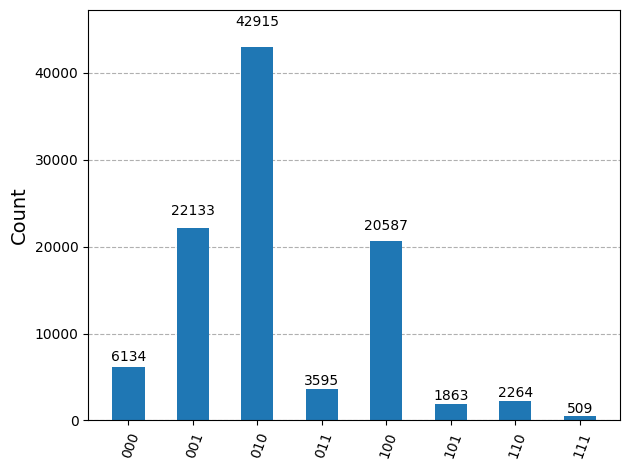

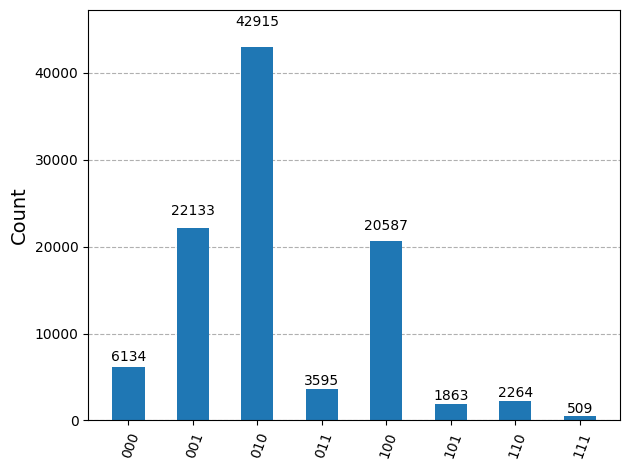

In [31]:
plot_histogram(counts)

## Gate count analysis

### Are all measurements required?
